<a href="https://colab.research.google.com/github/mkkim007/AIFFEL/blob/main/%5BE_03%5DStickerCamera.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [E-03] 카메라 스티커앱 만들기



패키지 설치

In [1]:
'''
!pip install opencv-python
!pip install cmake
!pip install dlib
'''

'\n!pip install opencv-python\n!pip install cmake\n!pip install dlib\n'

import module

In [2]:
import cv2                          # openCV - 이미지 처리
import matplotlib.pyplot as plt     # 이미지 출력
import numpy as np                  # 
import dlib                         # 얼굴검출
import math

## 1.사진 준비하기

###1.1 구글 드라이브 연동

먼저 구글 드라이브에 연동을 해서 사진을 가지고 오겠습니다. 

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


`model` 폴더와 `image`폴더를 만들어 줍니다.

In [4]:
!mkdir -p camera_sticker/models
!mkdir -p camera_sticker/images

구글 드라이브에 있는 사진들을 `images` 폴더에 copy 해줍니다.

In [5]:
!cp /content/gdrive/MyDrive/Data/image.png camera_sticker/images
!cp /content/gdrive/MyDrive/Data/cat-whiskers.png camera_sticker/images

### 1.2. 이미지 로드

이제 본격적으로 준비한 이미지를 불러옵니다.  
이미지 파일을 읽어 올 때는 `cv.imread()` 함수를 이용합니다.  
> #### cv.imread(fileName, flag)
- fileName : 이미지 파일의 경로
- flag : 이미지 파일을 읽을 때 option
    1. `cv2.IMREAD_COLOR`(1) : 이미지 파일을 Color로 읽어들임. 투명한 부분은 무시되며, Default값
    2. `cv2.IMREAD_GRAYSCALE`(0) : 이미지를 Grayscale로 읽어 들임. 실제 이미지 처리시 중간단계로 많이 사용.
    3. `cv2.IMREAD_UNCHANGED`(-1) : 이미지파일을 alpha channel까지 포함하여 읽어 들임.

[출처 - 이미지 다루기](https://opencv-python.readthedocs.io/en/latest/doc/01.imageStart/imageStart.html)


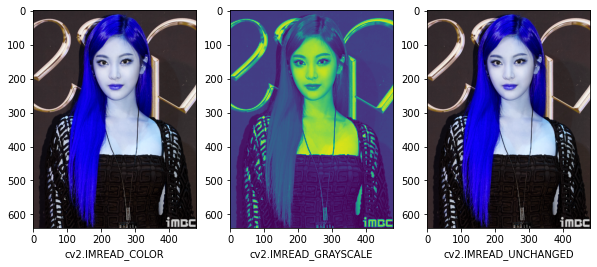

In [45]:
my_image_path = '/content/camera_sticker/images/image.png'
img_bgr_clolor = cv2.imread(my_image_path)                              # flag : 1
img_bgr_clolor = cv2.resize(img_bgr_clolor, (480,640))                  # 480X640 의 크기로 Resize

img_bgr_grayscale = cv2.imread(my_image_path, cv2.IMREAD_GRAYSCALE)     # flag : 0
img_bgr_grayscale = cv2.resize(img_bgr_grayscale, (480,640))            # 480X640 의 크기로 Resize

img_bgr_unchanged = cv2.imread(my_image_path, cv2.IMREAD_UNCHANGED)     # flag : -1
img_bgr_unchanged = cv2.resize(img_bgr_unchanged, (480,640))            # 480X640 의 크기로 Resize
img_show = img_bgr_clolor.copy()            # 출력용 이미지 별도 보관

fig = plt.figure()
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(img_bgr_clolor)
ax1.set_xlabel('cv2.IMREAD_COLOR')

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(img_bgr_grayscale)
ax2.set_xlabel('cv2.IMREAD_GRAYSCALE')

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(img_bgr_unchanged)
ax3.set_xlabel('cv2.IMREAD_UNCHANGED')

plt.rcParams["figure.figsize"] = (10,4)     #사이즈 조절
plt.show()

뭔가 색감이 이상하게 나옵니다  왜 그럴까요?  
웬만한 이미지 라이브러리(ex.matplotlib)는 이미지 채널을 **RGB(빨강, 녹색, 파랑)** 순으로 사용합니다.  
그러나 `opencv`는 이미지 채널을 **BGR(파랑, 녹색, 빨강)**을 사용합니다.   
그래서 `plt.imshow` 사용하기전에 `CV2.cvtColor`를 사용해 RGB 이미지로 꼭 바꿔줘야 합니다.

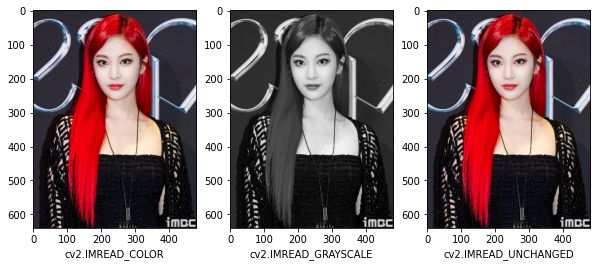

In [7]:
img_rgb = cv2.cvtColor(img_bgr_clolor, cv2.COLOR_BGR2RGB)
img_rgb_grayscale = cv2.cvtColor(img_bgr_grayscale, cv2.COLOR_BGR2RGB)
img_rgb_unchanged = cv2.cvtColor(img_bgr_unchanged, cv2.COLOR_BGR2RGB)


fig = plt.figure()
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(img_rgb)
ax1.set_xlabel('cv2.IMREAD_COLOR')

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(img_rgb_grayscale)
ax2.set_xlabel('cv2.IMREAD_GRAYSCALE')

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(img_rgb_unchanged)
ax3.set_xlabel('cv2.IMREAD_UNCHANGED')

plt.rcParams["figure.figsize"] = (10,4)     #사이즈 조절
plt.show()

## 2.얼굴 검출

우리는 얼굴 검출을 위해서 `dlib`패키지를 사용합니다.  
`dlib` 의 face detector는 __HOG__(Histogram of Oriented Gradient) feature를 사용해서 __SVM__(Support Vector Machine)의 sliding window로 얼굴을 찾습니다.  

자세한 알고리즘은 아래의 링크에 있습니다.  

[기계 학습은 즐겁다! Part4](https://medium.com/@jongdae.lim/%EA%B8%B0%EA%B3%84-%ED%95%99%EC%8A%B5-machine-learning-%EC%9D%80-%EC%A6%90%EA%B2%81%EB%8B%A4-part-4-63ed781eee3c) 



In [8]:
detector_hog = dlib.get_frontal_face_detector()   # detector 선언

In [9]:
img_rgb = cv2.cvtColor(img_bgr_clolor, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # detector_hog(image, num of img pyramid)

rectangles[[(167, 116) (322, 270)]]


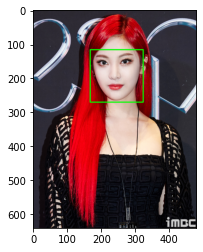

In [10]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 3.얼굴 랜드마크

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/E-8-8.png)  

얼굴을 찾았다면 이제 얼굴의 이목구비 위치를 찾아야 합니다! 그러기 위해서는 face landmark location 기술을 사용합니다. 저희는 Dlib에서 제공하는 모델을 사용하도록 하겠습니다.

In [11]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 
!mv shape_predictor_68_face_landmarks.dat.bz2 camera_sticker/models         
!cd camera_sticker/models && bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

--2021-07-26 15:21:14--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  36.2MB/s    in 1.7s    

2021-07-26 15:21:16 (36.2 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]

bzip2: Output file shape_predictor_68_face_landmarks.dat already exists.


In [12]:
model_path = 'camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [13]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


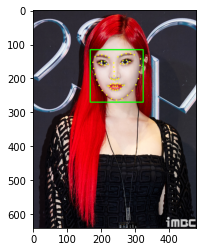

In [14]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

위와 같이 얼굴의 랜드마크가 이미지에 정확하게 출력된 것을 볼 수가 있습니다.

## 4.스티커 적용하기

이제 코에 고양이 수염을 붙여봅시다.  
완전히 코에 붙이기 보다는 눈(36)과 입술(48) 볼(2) 위치의 중간쯤에 붙이도록하겠습니다.

In [15]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30 
    x = landmark[30][0]     # x는 코가 중앙이니까 코로 설정
    y = (landmark[2][1]+landmark[36][1]+landmark[48][1])//3     # y는 세점의 평균으로 설정
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(237, 193)
(x,y) : (237,188)
(w,h) : (156,156)


스티커를 불러와 스티커의 사이즈를 얼굴 검출했던 상자의 크기로 resize 해줍니다.

In [16]:
sticker_path = '/content/camera_sticker/images/cat-whiskers.png'

img_sticker = cv2.imread(sticker_path)
print (img_sticker.shape)
img_sticker = cv2.resize(img_sticker, (w,h))

print (img_sticker.shape)

(512, 512, 3)
(156, 156, 3)


위에서 설정했던 x와 y는 중앙값 위치이기 때문에 각각을 top-left로 다시 정의해줍니다.

In [17]:
refined_x = x - w // 2  # left
refined_y = y - h // 2 # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (159,110)


만약에 스티커가 밖으로 나간다면 제거해줍니다!

In [18]:
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:]
    refined_y = 0

if refined_x < 0:
    img_sticker = img_sticker[-refined_x:]
    refined_x = 0    




이제 이미지에서 스티커의 크기만큼 crop 하여 `sticker_area`라고 정의해줍니다.  
만약 스티커(`img_sticker`)가 255(흰색)이면 원본 이미지(`sticker_area`)를 넣고 아니면(검정색) 스티커 이미지(`img_sticker`)를 넣습니다 

In [19]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

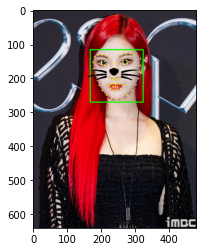

In [20]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

위와 같이 잘 나오는 것을 확인할 수 있습니다.

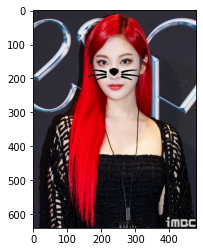

In [21]:
sticker_area = img_bgr_clolor[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr_clolor[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr_clolor, cv2.COLOR_BGR2RGB))
plt.show()

박스와 랜드마크를 모두 안보이게 하고 싶다면 아까 위에서 제일 처음에 불러왔던 `img_bgr_color`를 사용해서 그 위에 똑같은 방법으로 그려줍니다!

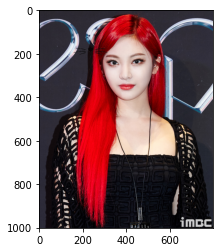

In [22]:
img_bgr_clolor = cv2.imread(my_image_path)
sticker_area = img_bgr_clolor[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr_clolor[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8), 0.5, 0)
plt.imshow(cv2.cvtColor(img_bgr_clolor, cv2.COLOR_BGR2RGB))
plt.show()

`cv2.addWeighted()`를 이용해서 좀더 자연스럽게 투명한 고양이 수염을 만들어 보았습니다. (~~근데 진한게 더 예쁜것 같아요~~)

## 5.다양한 사진으로 문제점 찾아보기

### 5.1 측면 사진

####5.1.1 약간 측면 사진

In [23]:
!cp /content/gdrive/MyDrive/Data/side.jpg camera_sticker/images

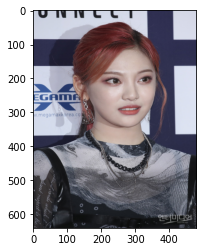

In [24]:
my_image_path = '/content/camera_sticker/images/side.jpg'
img_side = cv2.imread(my_image_path)   
img_side = cv2.resize(img_side, (480, 640))    
img_show = img_side.copy()     
plt.imshow(cv2.cvtColor(img_side, cv2.COLOR_BGR2RGB))
plt.show()

먼저 약간의 측면 사진을 들고 왔습니다.

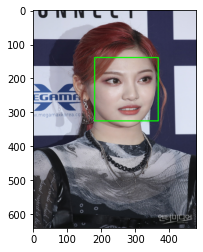

68


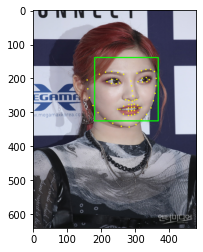

In [25]:
detector_hog = dlib.get_frontal_face_detector()   # detector 선언
dlib_rects = detector_hog(img_side, 1)   # detector_hog(image, num of img pyramid)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_side, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

얼굴 검출과 랜드마크도 잘 되는 것 같습니다.

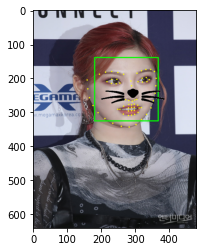

In [26]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0]
    y = (landmark[2][1]+landmark[36][1]+landmark[48][1])//3
    w = dlib_rect.width()
    h = dlib_rect.width()


sticker_path = '/content/camera_sticker/images/cat-whiskers.png'

img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))


refined_x = x - w // 2  # left
refined_y = y - h // 2 # top


if refined_y < 0:
    img_sticker = img_sticker[-refined_y:]
    refined_y = 0


sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

그렇다보니 고양이 수염도 잘 달리는 군요!

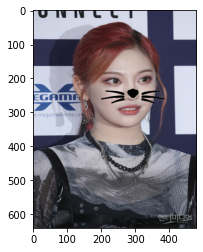

In [27]:
sticker_area = img_side[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_side[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_side, cv2.COLOR_BGR2RGB))
plt.show()

#### 5.1.2 완전한 측면 사진

In [28]:
!cp /content/gdrive/MyDrive/Data/side2.jpg camera_sticker/images

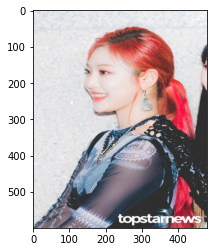

In [29]:
my_image_path = '/content/camera_sticker/images/side2.jpg'
img_side = cv2.imread(my_image_path)   
img_side = cv2.resize(img_side, (480, 600))    
img_show = img_side.copy()     
plt.imshow(cv2.cvtColor(img_side, cv2.COLOR_BGR2RGB))
plt.show()

그 다음으로 좀 더 측면인 사진을 가지고 와봤습니다.

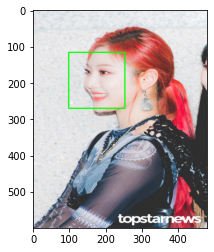

68


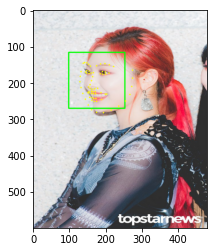

In [30]:
detector_hog = dlib.get_frontal_face_detector()   # detector 선언
dlib_rects = detector_hog(img_side, 1)   # detector_hog(image, num of img pyramid)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_side, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

역시나 얼굴검출과 랜드마킹 모두 잘합니다.

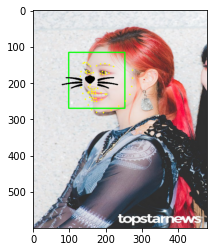

In [31]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0]
    y = (landmark[2][1]+landmark[36][1]+landmark[48][1])//3
    w = dlib_rect.width()
    h = dlib_rect.width()


sticker_path = '/content/camera_sticker/images/cat-whiskers.png'

img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))


refined_x = x - w // 2  # left
refined_y = y - h // 2 # top


if refined_y < 0:
    img_sticker = img_sticker[-refined_y:]
    refined_y = 0


sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

그래서 적절한 위치에 잘 붙습니다.

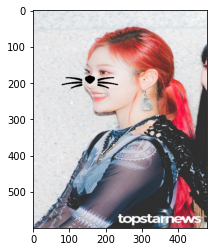

In [32]:
sticker_area = img_side[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_side[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_side, cv2.COLOR_BGR2RGB))
plt.show()

그러나 좀 차원이 너무 평면적으로 나오게 되는 것이 문제점인 것 같습니다.

### 5.2 돌아간 사진

#### 5.2.1 고개가 돌아간 사진

In [33]:
!cp /content/gdrive/MyDrive/Data/rotation2.jpg camera_sticker/images

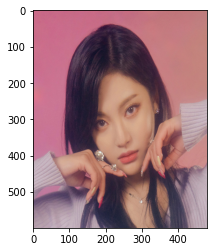

In [34]:
my_image_path = '/content/camera_sticker/images/rotation2.jpg'
img_rotation = cv2.imread(my_image_path)   
img_rotation = cv2.resize(img_rotation, (480, 600))    
img_show = img_rotation.copy()     
plt.imshow(cv2.cvtColor(img_rotation, cv2.COLOR_BGR2RGB))
plt.show()

이번에는 고개가 약간 돌아간 사진을 사용해보겠습니다.

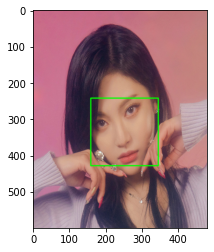

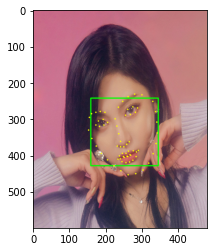

In [35]:
detector_hog = dlib.get_frontal_face_detector()   # detector 선언
dlib_rects = detector_hog(img_rotation, 1)   # detector_hog(image, num of img pyramid)


for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rotation, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()


역시나 얼굴검출, 랜드마크 다 잘됩니다.

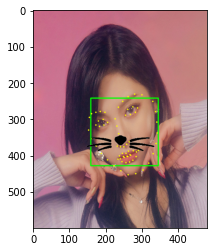

In [36]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0]
    y = (landmark[2][1]+landmark[36][1]+landmark[48][1])//3
    w = dlib_rect.width()
    h = dlib_rect.width()


sticker_path = '/content/camera_sticker/images/cat-whiskers.png'

img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))


refined_x = x - w // 2  # left
refined_y = y - h // 2 # top

if refined_y < 0:
    img_sticker = img_sticker[-refined_y:]
    refined_y = 0

sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

그러나 고양이를 붙여주게 되면 이렇게 좀 부자연스럽게 붙여지게 됩니다.

그래서 왼쪽 볼(2)와 오른쪽 볼(14)의 기울기를 구하여 기울어진 각도를 atan를 이용하여 아래와 같이 구해줍니다.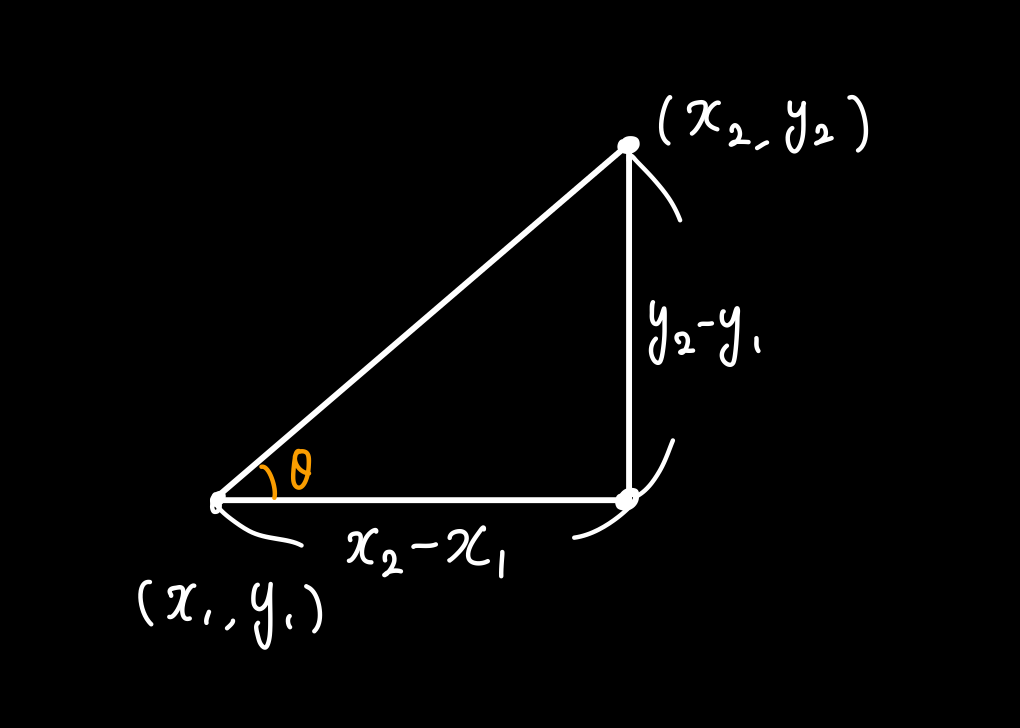

In [37]:
img_show = img_rotation.copy()          # 아무것도 안그려진 이미지    
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):

    
    x = landmark[30][0]
    y = (landmark[2][1]+landmark[36][1]+landmark[48][1])//3
    x1 = landmark[2][0]
    x2 = landmark[14][0]
    y1 = landmark[2][1]
    y2 = landmark[14][1]
    w = dlib_rect.width()
    h = dlib_rect.width()



sticker_path = '/content/camera_sticker/images/cat-whiskers.png'

img_sticker = cv2.imread(sticker_path)

img_sticker = cv2.resize(img_sticker, (w,h))

angle = math.atan((abs(y2-y1))/(abs(x2-x1)))/math.pi*180

각도를 구했다면 `getRotationMatrix`를 이용하여 회전을 시켜줍니다. 여기서 주의할 점은 돌려서 생긴 빈칸들을 `borderValue` 인자를 이용하여 전부 흰색(255,255,255)로 채워줘야 합니다.

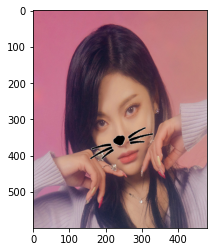

In [38]:

matrix = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
img_sticker_rotation = cv2.warpAffine(img_sticker, matrix, (w, h),borderValue=(255,255,255))

refined_x = x - w // 2  # left
refined_y = y - h // 2 # top

if refined_y < 0:
    img_sticker_rotation = img_sticker_rotation[-refined_y:]
    refined_y = 0


sticker_area = img_show[refined_y:refined_y+img_sticker_rotation.shape[0], refined_x:refined_x+img_sticker_rotation.shape[1]]
img_show[refined_y:refined_y+img_sticker_rotation.shape[0], refined_x:refined_x+img_sticker_rotation.shape[1]] = \
    np.where(img_sticker_rotation==255,sticker_area,img_sticker_rotation).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

짜잔,,, 완전 잘되는군요!!

#### 5.2.2 사진 자체가 돌아간 사진

In [39]:
!cp /content/gdrive/MyDrive/Data/rotation.jpg camera_sticker/images

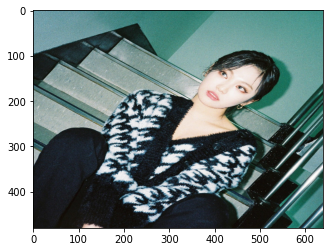

In [40]:
my_image_path = '/content/camera_sticker/images/rotation.jpg'
img_rotation = cv2.imread(my_image_path)   
img_rotation = cv2.resize(img_rotation, (640, 480))    
img_show = img_rotation.copy()     
plt.imshow(cv2.cvtColor(img_rotation, cv2.COLOR_BGR2RGB))
plt.show()

이번에는 사진 자체가 좀 돌아간 사진을 들고 왔습니다.

rectangles[]


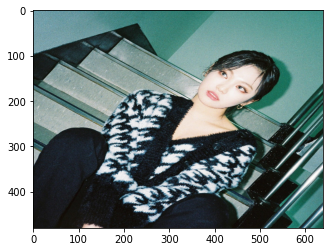

In [41]:
detector_hog = dlib.get_frontal_face_detector()   # detector 선언
dlib_rects = detector_hog(img_rotation, 1)   # detector_hog(image, num of img pyramid)
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

허걱,, 아예 얼굴 검출부터 못해 냅니다 ㅜㅜ 이렇게 되면 아예 스티커를 붙일 수 없겠군요. 돌아간만큼 반대로 돌리면 되지만 일반화하기 힘들것 같습니다.

### 5.3 멀리서 찍은 사진

In [42]:
!cp /content/gdrive/MyDrive/Data/far.jpg camera_sticker/images

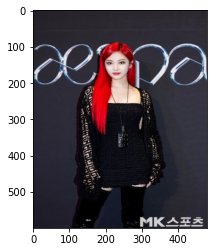

In [43]:
my_image_path = '/content/camera_sticker/images/far.jpg'
img_far = cv2.imread(my_image_path)   
img_far = cv2.resize(img_far, (480, 600))    
img_show = img_far.copy()     
plt.imshow(cv2.cvtColor(img_far, cv2.COLOR_BGR2RGB))
plt.show()

젤 위에서 했던 사진보다 좀 더 멀리서 찍은 사진을 가져왔습니다.

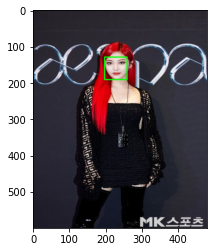

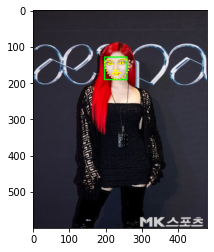

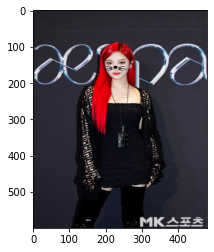

In [44]:

detector_hog = dlib.get_frontal_face_detector()   # detector 선언
dlib_rects = detector_hog(img_far, 1)   # detector_hog(image, num of img pyramid)


for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_far, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0]
    y = (landmark[2][1]+landmark[36][1]+landmark[48][1])//3
    w = dlib_rect.width()
    h = dlib_rect.width()


sticker_path = '/content/camera_sticker/images/cat-whiskers.png'

img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))


refined_x = x - w // 2  # left
refined_y = y - h // 2 # top

if refined_y < 0:
    img_sticker = img_sticker[-refined_y:]
    refined_y = 0

sticker_area = img_far[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_far[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_far, cv2.COLOR_BGR2RGB))
plt.show()

멀리 있어도 얼굴인식만 되면 잘 됩니다!!

# 🤔회고록🤔
- 랜드마크를 이용해서 중심 좌표를 설정한후 top-left로 다시 설정해주는 것을 이해하기가 어려웠다 (~~지금생각해보니 별거 아닌데,,~~)
- 얼굴이 회전되어있을때 기울기에 따라 스티커도 회전하면되지만 측면사진에서 공간적으로 돌아갔을 때는 어떻게 해야할까??  --> 이거에 대해서 아지트에 많이 올라왔는데 구현하기에 엄두가 안났다,,, 너무 어려워요ㅜㅜ
- 생각보다 랜드마크를 잘해서 신기했다. 